In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error


In [4]:
df = pd.read_csv(r"C:\Users\Taizeen\Downloads\data science assignments\Timeseries\Timeseries\exchange_rate.csv")
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [7]:
df['Date'] = pd.to_datetime(
    df['Date'],
    dayfirst=True,
    errors='coerce'
)

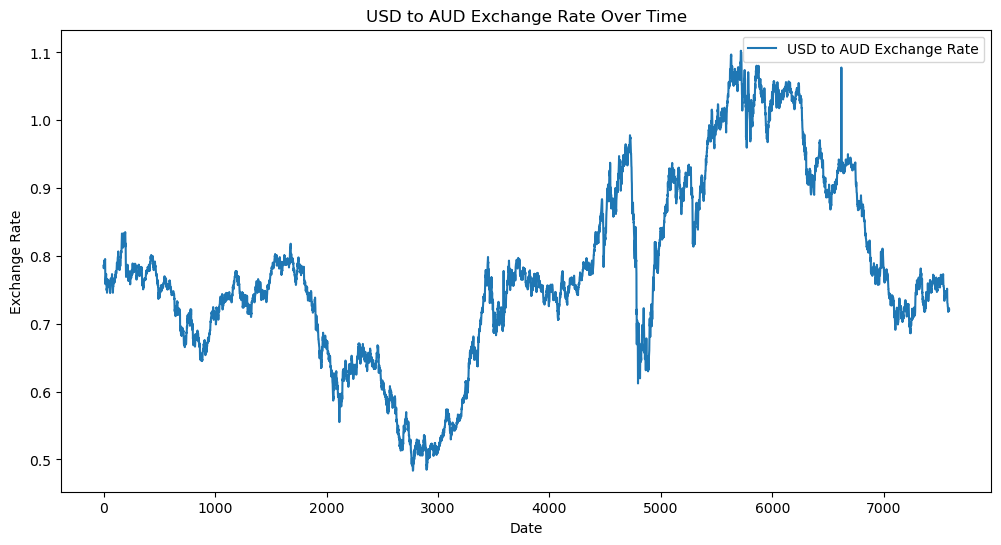

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df['USD_AUD'], label='USD to AUD Exchange Rate')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


In [11]:
df.isnull().sum()

Date       0
USD_AUD    0
dtype: int64

In [20]:
df = df.ffill()

In [21]:
adf_result = adfuller(df['USD_AUD'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])



ADF Statistic: -1.664994180738078
p-value: 0.44923273535982894


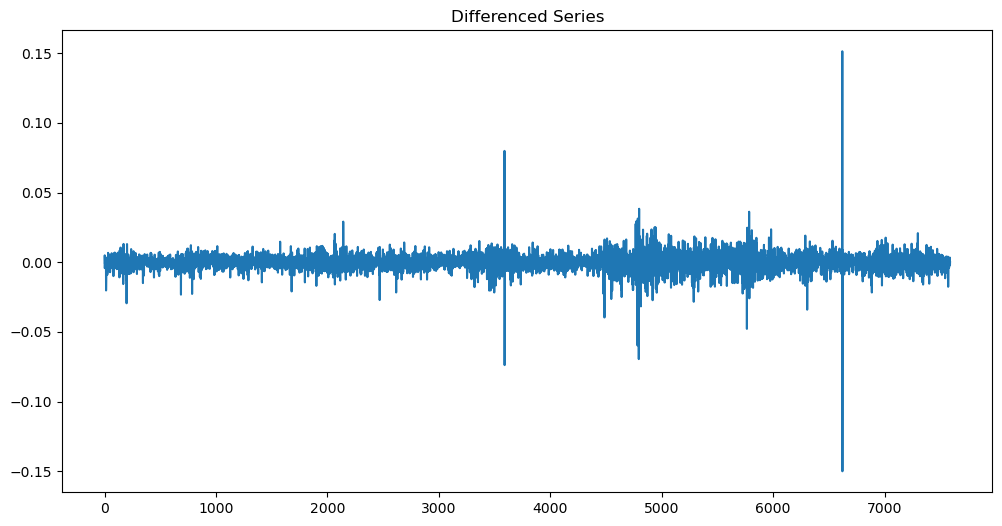

In [22]:
df_diff = df['USD_AUD'].diff().dropna()
plt.figure(figsize=(12,6))
plt.plot(df_diff)
plt.title('Differenced Series')
plt.show()


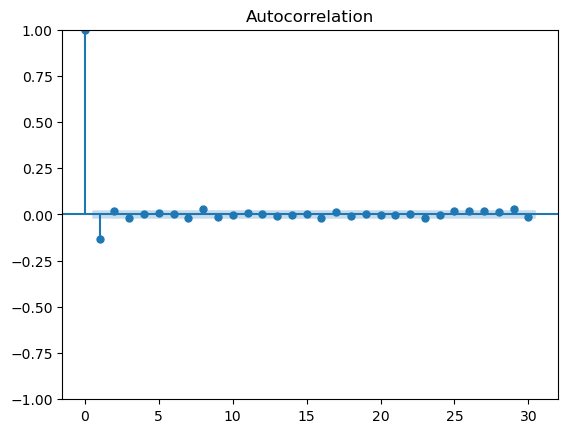

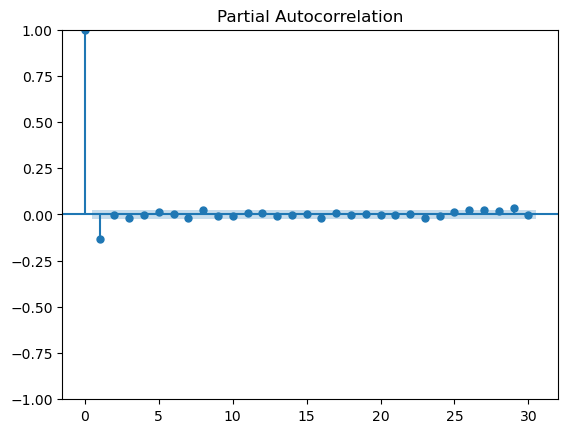

In [23]:
plot_acf(df_diff, lags=30)
plt.show()

plot_pacf(df_diff, lags=30)
plt.show()


In [25]:
train = df.iloc[:-30]
test = df.iloc[-30:]


In [26]:
arima_model = ARIMA(train['USD_AUD'], order=(1,1,1))
arima_fit = arima_model.fit()
print(arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 7558
Model:                 ARIMA(1, 1, 1)   Log Likelihood               27934.471
Date:                Fri, 26 Dec 2025   AIC                         -55862.942
Time:                        20:03:50   BIC                         -55842.152
Sample:                             0   HQIC                        -55855.806
                               - 7558                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1262      0.045     -2.783      0.005      -0.215      -0.037
ma.L1         -0.0056      0.045     -0.123      0.902      -0.095       0.083
sigma2      3.604e-05   9.99e-08    360.760      0.0

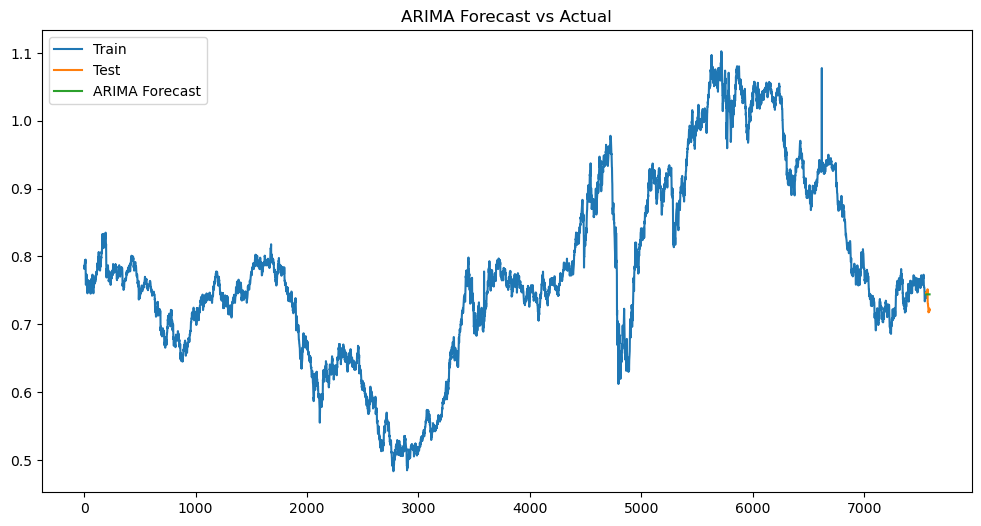

In [27]:
arima_forecast = arima_fit.forecast(steps=30)

plt.figure(figsize=(12,6))
plt.plot(train.index, train['USD_AUD'], label='Train')
plt.plot(test.index, test['USD_AUD'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()


In [29]:
hw_model = ExponentialSmoothing(
    train['USD_AUD'],
    trend='add',
    seasonal=None
)
hw_fit = hw_model.fit()


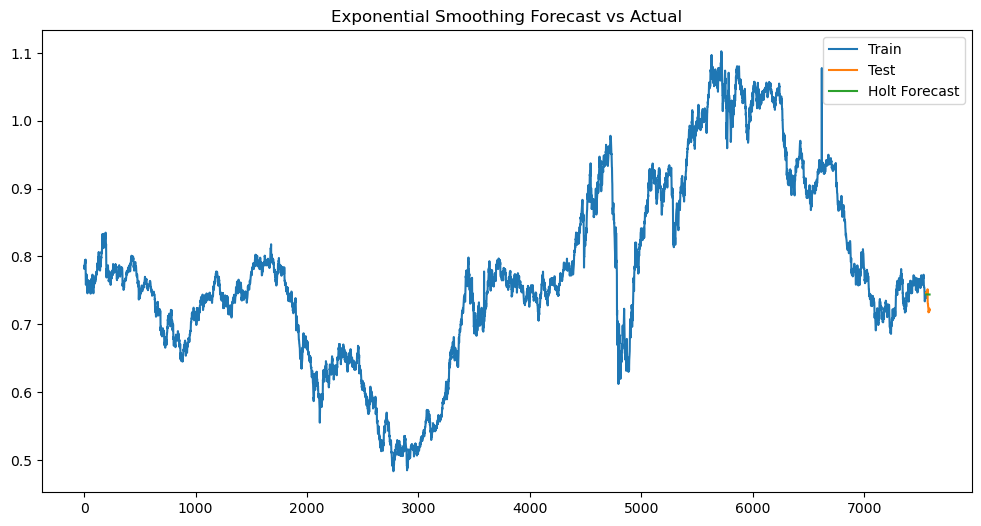

In [30]:
hw_forecast = hw_fit.forecast(30)

plt.figure(figsize=(12,6))
plt.plot(train.index, train['USD_AUD'], label='Train')
plt.plot(test.index, test['USD_AUD'], label='Test')
plt.plot(test.index, hw_forecast, label='Holt Forecast')
plt.legend()
plt.title('Exponential Smoothing Forecast vs Actual')
plt.show()


In [31]:
def evaluate_model(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape


In [32]:
arima_mae, arima_rmse, arima_mape = evaluate_model(
    test['USD_AUD'], arima_forecast)

hw_mae, hw_rmse, hw_mape = evaluate_model(
    test['USD_AUD'], hw_forecast)

results = pd.DataFrame({
    'Model': ['ARIMA', 'Exponential Smoothing'],
    'MAE': [arima_mae, hw_mae],
    'RMSE': [arima_rmse, hw_rmse],
    'MAPE (%)': [arima_mape, hw_mape]
})

results


,Model,MAE,RMSE,MAPE (%)
0,ARIMA,0.013495,0.016632,1.863221
1,Exponential Smoothing,0.013425,0.016500,1.853453
